In [1]:
import rnutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import SGD

rnutil: Los archivos de los conjuntos de datos que ofrece este paquete también están disponibles en https://github.com/facundoq/redes-neuronales-util/tree/main/rnutil/data para descargar de forma individual
rnutil: Agregando el parámetro local=True en las funciones rnutil.load_dataset_numpy, rnutil.load_dataset_pandas y rnutil.load_image se puede cargar una versión local de un archivo en lugar de la versión que ofrece este paquete.


In [2]:
def plot_coefients(model, df):
    w, b = model.get_weights()

    # Agrego el bias y w a un vector de parámetros
    parameters = np.hstack( [w.squeeze(),b])
    indices    = range(len(parameters))

    plt.figure()
    plt.bar(indices,parameters)

    # Agrego el bias a la lista de nombres de columnas
    columns = list(df.columns) + ["BIAS"]

    # Quito la esperanza de vida de esta lista (es la var a predecir)
    del columns [2]

    plt.xticks(indices,columns,rotation="vertical")
    plt.show()

In [3]:
def to_x_y(df):
    x = df.to_numpy()
    x, y  = np.hstack([x[:,0:2],x[:,3:]]),x[:,2:3]
    d_out = y.shape[1]
    d_in  = x.shape[1]
    x     = (x - x.mean(axis=1, keepdims=True)) / x.std(axis=1, keepdims=True)
    return x, y

## Carga del dataset

In [4]:
version_cruda = True

if version_cruda:
    df= rnutil.load_dataset_pandas("who_life_expectancy.csv")

    print(df.columns)
    
    # Quitar filas con valores faltantes
    df = df.dropna()

    # Quitar columna Country (es como un identificador)
    del df["Country"]
    
    # Convertir columna status a valores numéricos de 0 a 2
    df["Status"] = df["Status"].astype("category").cat.codes
else:
    df = rnutil.load_dataset_pandas("who_life_expectancy_no_missing_numeric.csv")

    df.describe()


Loading file from package rnutil (/home/adrian/.conda/envs/rn/lib/python3.10/site-packages/rnutil/data)...
Done
Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')


#  Convertir datos a numpy y entrenar modelo

Separar en columnas de entrada y de salida:

In [7]:
x, y = to_x_y(df)

d_out = y.shape[1]
d_in  = x.shape[1]

Creación del modelo inicial:

In [8]:
print("Inicialización aleatoria del modelo; vuelve a correr esta celda para obtener otros resultados")

modelo = Sequential([Dense(d_out, input_shape=(d_in,), activation=None)])

Inicialización aleatoria del modelo; vuelve a correr esta celda para obtener otros resultados


2022-04-03 20:30:53.338084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-03 20:30:53.364299: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-03 20:30:53.364456: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-03 20:30:53.364972: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Creo el optimizador y compilo el modelo para usarlo:

In [9]:
modelo.compile(
    optimizer = SGD(0.001),
    loss = 'mse',
    metrics = ['mae']
)

Entrenamiento del modelo:

In [10]:
history  = modelo.fit(
    x,
    y,
    epochs     = 15,
    batch_size = 16
)

Epoch 1/15
104/104 [==============================] - 1s 920us/step - loss: 773.9500 - mae: 20.3471
Epoch 2/15
104/104 [==============================] - 0s 730us/step - loss: 169.8223 - mae: 8.6665
Epoch 3/15
104/104 [==============================] - 0s 710us/step - loss: 152.3161 - mae: 8.3955
Epoch 4/15
104/104 [==============================] - 0s 709us/step - loss: 138.7632 - mae: 8.2093
Epoch 5/15
104/104 [==============================] - 0s 693us/step - loss: 128.4127 - mae: 8.0341
Epoch 6/15
104/104 [==============================] - 0s 684us/step - loss: 120.3721 - mae: 7.9033
Epoch 7/15
104/104 [==============================] - 0s 671us/step - loss: 114.1836 - mae: 7.8073
Epoch 8/15
104/104 [==============================] - 0s 667us/step - loss: 109.3002 - mae: 7.7222
Epoch 9/15
104/104 [==============================] - 0s 657us/step - loss: 105.4669 - mae: 7.6509
Epoch 10/15
104/104 [==============================] - 0s 668us/step - loss: 102.5085 - mae: 7.6202
Epoch 11

Visualización:

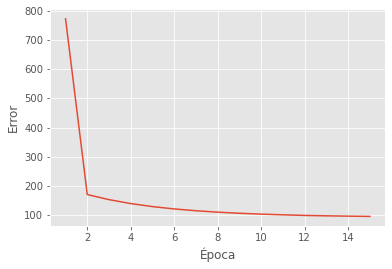

In [11]:
rnutil.plot_loss(history.history["loss"])

# Visualización de los coeficientes resultantes de la regresión lineal

El siguiente gráfico de barras muestra la magnitud (y signo) de los coeficientes `w` de la regresión lineal, además del sesgo. De esta forma se puede intentar explicar la importancia de cada uno de los atributos para el modelo.

In [12]:
for layer in modelo.layers:
    print(layer.get_config(), layer.get_weights())

{'name': 'dense', 'trainable': True, 'batch_input_shape': (None, 20), 'dtype': 'float32', 'units': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None} [array([[ 4.093186 ],
       [-1.6838768],
       [-2.0803878],
       [-2.1462262],
       [-1.3811743],
       [-0.3486908],
       [-2.1556797],
       [ 1.6791359],
       [-1.7920681],
       [-2.4040608],
       [-1.7164127],
       [-1.5158776],
       [-1.467495 ],
       [-2.1021883],
       [ 8.811891 ],
       [13.435937 ],
       [-2.1878195],
       [-1.7503867],
       [-1.7145888],
       [-2.131536 ]], dtype=float32), array([6.187794], dtype=float32)]


Dibujo un gráfico de barra de los parámetros (coeficientes de cada atributo):

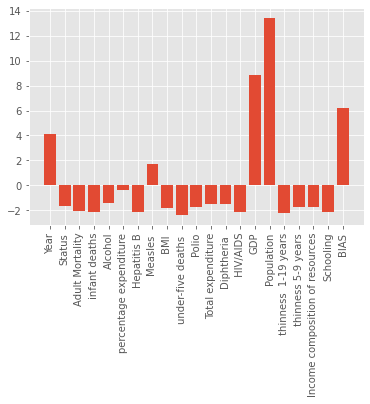

In [13]:
plot_coefients(modelo, df)

**5. Podemos analizar qué variables utiliza el modelo para realizar la 	predicción en base a los valores de sus pesos. Analizá los pesos 	del modelo para determinar cuáles son las variables correspondientes que más impacto tienen en la predicción. Poniéndote en lugar de un estadista, ¿cuáles de estas variables es más importante influenciar si se busca aumentar la esperanza de vida?**

Variables con mas impacto:

* **Population**: Este coeficiente es muy obivio ya que a major poblacion tenemos mas posibibildad 
de aumentar la esperanza de vida o personas con major edad.
* **GDP (Producto bruto interno)**: Esta propiedad tambien es mediana mente obvia, ya que cuando mayor es el consumo de viene y servicios dentro del pais en un periodo dado mas  posibilidad hay de que individios de edades mayores los consuman.
* **Year**: Este es el coeficiente mas directo pero no es el que tiene mas influencia. Entiendo que se refiere a la edad maxima.

Creo que lo mejor e diminuir los coecifientes que restan com la mortalidad en adultos y infantes, el estatus y la escolaridad.

**6. Podría argumentarse que algunas variables deberían quitarse, debido a que 	tienen una relación muy directa con la variable a predecir. En particular, la mortalidad adulta e infantil están demasiado relacionadas con la expectativa de vida, y entonces el modelo no aprende algo útil, ya que no son variables que un estadista pueda cambiar directamente. Quitá esas variables del conjunto de datos y repetí el análisis. ¿Cuáles son las variables relevantes ahora?**

In [20]:
df.columns

Index(['Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')

In [21]:
df2 = df.drop(['Adult Mortality', 'infant deaths', 'under-five deaths '], axis=1)

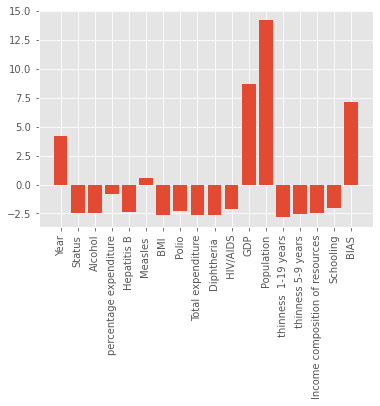

In [22]:
x, y  = to_x_y(df2)

model = Sequential([Dense(d_out, input_shape=(x.shape[1],), activation=None)])

model.compile(
    optimizer = SGD(0.001),
    loss = 'mse',
    metrics = ['mae']
)

history  = model.fit(
    x,
    y,
    epochs     = 15,
    batch_size = 16, 
    verbose    = 0
)

plot_coefients(model, df2)

Las variables relevantes positivas siguen siendo las mismas. Las negativas en su mayoria ahora estan pradicamente igualadas:

* Todas la referentes a enfermedades tiene simiales importancias Hepatitis B, Polio, Difteria. 
* Ademas el indice se masa corporal como la delgadez toman mas importancia. 
* Sarampión aumenta las expectativa de vida lo cual no tiene mucho sentido.
* El coeficiente de status social resta mas. Entiendo que se refiere a que a mayor status social disminuye la expectativa de vida, tendra que ver con el stress?